## 資料清洗

匯入模塊

In [112]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [113]:
file = r"C:\Users\z9875\OneDrive\桌面\107年 高屏空品區\107年鳳山站_20190315.xls"

轉成dataframe，並查看資料大概

In [114]:
df = pd.read_excel(file)
df.head(15)

,日期,測站,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
0,2018/01/01,鳳山,AMB_TEMP,17.5,17.3,17.1,16.6,16.4,16.7,16.7,...,25.5,25.2,24.2,22.7,22.1,22,21,20.1,19.5,19
1,2018/01/01,鳳山,CH4,2.3,2.3,2.3,2.3,2.3,2.3,2.3,...,2.1,2.1,2.1,2,2,2.1,2.1,2.1,2.1,2.1
2,2018/01/01,鳳山,CO,0.94,0.94,0.94,0.84,0.81,0.81,0.8,...,0.67,0.68,0.76,0.75,0.9,0.87,0.66,0.66,0.63,0.62
3,2018/01/01,鳳山,NMHC,0.36,0.34,0.38,0.32,0.32,0.34,0.4,...,0.17,0.17,0.2,0.21,0.26,0.27,0.18,0.18,0.19,0.22
4,2018/01/01,鳳山,NO,1.9,1.5,1.8,1.6,2.3,6.4,7.6,...,1.3,1.1,1.1,0.6,0.7,0.8,0.7,0.7,0.6,0.8
5,2018/01/01,鳳山,NO2,31,28,29,26,26,26,25,...,19,18,23,21,30,34,25,24,26,28
6,2018/01/01,鳳山,NOx,33,30,31,27,28,33,33,...,21,20,25,21,31,35,26,24,26,28
7,2018/01/01,鳳山,O3,5.2,4.5,3.4,4.8,3.3,2.1,1.9,...,72,68,56,47,36,28,26,22,16,11
8,2018/01/01,鳳山,PH_RAIN,NR,NR,NR,NR,NR,NR,NR,...,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR
9,2018/01/01,鳳山,PM10,113,109,106,105,99,96,98,...,126,132,118,115,125,129,145,142,142,122


取出所需之pm2.5資料

In [115]:
df_pm = df[df["測項"] == "PM2.5"]

reindex由1開始並將columns轉為str

In [116]:
df_pm.index = range(1, len(df_pm)+1)
df_pm = df_pm.drop(["測站","測項"], axis=1)
df_pm.columns = ["日期\時間(HR)"] + [str(i) for i in range(0, 24)]
df_pm.head(20)
df_pm_copy = df_pm

以上可以發現資料中有不少缺值和無效值，閱讀環保署檔案之readme後:

    # 表示儀器檢核為無效值 
    * 表示程式檢核為無效值 
    x 表示人工檢核為無效值
    NR 表示無降雨
    空白 表示缺值
    風向資料888代表無風，999則代表儀器故障。

接下來將缺值做填補，我一開始想到的是用前後兩天之資料來做補值

In [117]:
def fill(df, col):
    
    invalid_mask = df[col].apply(lambda x: type(x) == str or pd.isna(x)) 
    #*或X或#皆為STR，空值為NAN用isna函式找出
    invalid_indexes = df[col][invalid_mask].index
    #濾出無效之index
    df[col][invalid_mask] = np.NAN
    #先將這些值設為NAN
    for invalid_index in invalid_indexes: #分別對每個無效值做填補
        
        count_front = 0
        count_back = 0
        total = 0
         
        i = 1
        while count_front < 2 :
            if invalid_index - i == 0 : #若index-i後為0表示前面無值(index從1開始)，就停下
                break
            elif not pd.isna(df.loc[invalid_index -i, col]): #如果此項有值則加到count_front
                total += df.loc[invalid_index -i, col]  
                count_front += 1 
            i += 1 

        i = 1        
        while count_back < (4 - count_front) :#若前面數值不夠，則往後取值正常為 4-2 = 2項
            if invalid_index + i  == len(df) + 1 :#如果到最後+1沒有值了，就停下
                break
            elif not pd.isna(df.loc[invalid_index + i, col]) :#如果此項有值則加到count_back
                total += df.loc[invalid_index + i, col]  
                count_back += 1
            i += 1 

        

        if count_back < 2 :#若後面數值不夠，則再回到前面

            while count_front < 4 - count_back:  #若後面取1項則還需要取1項

                if invalid_index - i == 0 : #如果前面沒有值了，就停下
                    break

                elif not pd.isna(df.loc[invalid_index -i, col]) :#如果此項有值則加到count_front
                    total += df.loc[invalid_index -i, col]  
                    count_front += 1 
                i += 1 
                
        if count_front + count_back == 4  : #若有找到4個值則填入
            df.loc[invalid_index, col] = int(total/4)
            
        else : # 會發生表示資料集太小，可能輸入錯
            print(f"{invalid_index}無值")
    

填補缺值

In [118]:
for col in df_pm.columns[1:]:
    fill(df_pm, col)

In [119]:
df_pm.head(20)

,日期\時間(HR),0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
1,2018/01/01,69,66,67,72,72,66,60,52,53,...,58,57,40,30,32,34,42,36,39,44
2,2018/01/02,51,45,33,34,42,44,40,41,42,...,23,36,33,32,18,19,28,41,28,28
3,2018/01/03,24,44,50,56,58,55,46,49,53,...,33,46,41,34,42,42,45,44,46,50
4,2018/01/04,53,58,55,44,38,38,32,23,22,...,55,58,55,61,64,68,51,30,23,28
5,2018/01/05,28,24,17,28,19,19,13,18,27,...,28,36,34,36,44,41,44,30,28,22
6,2018/01/06,23,13,11,16,16,17,19,34,38,...,25,35,55,61,56,46,41,46,36,30
7,2018/01/07,18,21,14,14,8,11,13,17,21,...,45,46,39,32,27,19,23,28,42,51
8,2018/01/08,49,42,41,36,35,24,23,21,27,...,2,1,10,12,13,10,17,7,2,1
9,2018/01/09,1,1,1,11,3,1,1,2,3,...,17,23,24,27,10,12,13,21,27,36
10,2018/01/10,39,36,25,22,10,11,6,14,13,...,24,29,32,34,36,36,30,28,21,27


In [120]:
df_pm.loc[19,:].values[1:]

array([61, 67, 60, 55, 50, 53, 55, 57, 74, 86, 103, 93, 78, 51, 35, 41,
       52, 55, 47, 40, 46, 46, 46, 39], dtype=object)

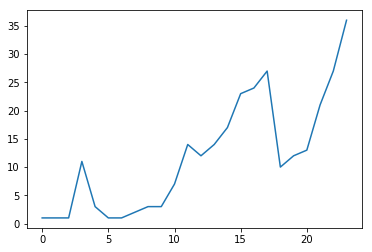

In [121]:
x = [i for i in range(0, 24)]
y1 = df_pm.loc[9,:].values[1:]
#df_pm.loc[19,:].values[1:]
#y2 = df_pm.loc[19,:].values[1:]


plt.plot(x, y1)
#plt.plot(x, y2)

在重新觀察資料之後，我發現PM2.5之高低似乎跟前後數小時比較有相關性，重新整理資料

先把空值統一為NAN

In [122]:
def invaild_to_NAN(df):
    for col in df.columns:
        invalid_mask = df[col].apply(lambda x: type(x) == str or pd.isna(x))
        df[col][invalid_mask] = np.NAN

In [123]:
file = r"C:\Users\z9875\OneDrive\桌面\107年 高屏空品區\107年鳳山站_20190315.xls"

df = pd.read_excel(file,index_col="日期")
df_pm = df[df["測項"] == "PM2.5"]
df_pm = df_pm.drop(["測站","測項"], axis=1)
df_pm.columns =[i for i in range(0, 24)]
invaild_to_NAN(df_pm)

df_pm = df_pm.T #將表格作轉置

df_pm[df_pm.columns[:14]]

日期,2018/01/01,2018/01/02,2018/01/03,2018/01/04,2018/01/05,2018/01/06,2018/01/07,2018/01/08,2018/01/09,2018/01/10,2018/01/11,2018/01/12,2018/01/13,2018/01/14
0,69,51,24,53,28,23,18,49,1,39,24,23,46,33
1,66,45,44,58,24,13,21,42,1,36,25,19,52,34
2,67,33,50,55,17,11,14,41,1,25,14,24,51,30
3,72,34,56,44,28,16,14,36,11,22,7,23,45,24
4,72,42,58,38,19,16,8,35,3,10,5,16,39,27
5,66,44,55,38,19,17,11,24,1,11,5,5,40,32
6,60,40,46,32,13,19,13,23,1,6,12,7,44,32
7,52,41,49,23,18,34,17,21,2,14,18,16,41,25
8,53,42,53,22,27,38,21,27,3,13,25,21,42,19
9,56,55,64,28,28,40,23,36,3,7,23,18,46,27


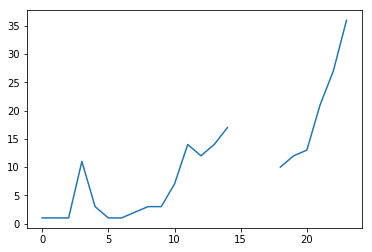

In [124]:
x = df_pm.index
y = df_pm["2018/01/09"]

plt.plot(x, y)

In [125]:
def fill2(df):
    for day in df.columns :#每天的資料
    
        invalid_mask = df[day].apply(lambda x: pd.isna(x)) 
        #*或X或#皆為STR，空值為NAN用isna函式找出
        invalid_indexes = df[day][invalid_mask].index
        #濾出無效之index
        
        for invalid_index in invalid_indexes: #分別對每個無效值做填補

            count_front = 0
            count_back = 0
            total = 0

            i = 1
            while count_front < 2 :
                if invalid_index - i < 0 : #若index-i後為0表示前面無值(index從1開始)，就停下
                    break
                elif not pd.isna(df.loc[invalid_index -i, day]): #如果此項有值則加到count_front
                    total += df.loc[invalid_index -i, day]  
                    count_front += 1 
                i += 1 

            i = 1        
            while count_back < (4 - count_front) :#若前面數值不夠，則往後取值正常為 4-2 = 2項
                if invalid_index + i  > 23  :#如果到最後+1沒有值了，就停下
                    break
                elif not pd.isna(df.loc[invalid_index + i, day]) :#如果此項有值則加到count_back
                    total += df.loc[invalid_index + i, day]  
                    count_back += 1
                i += 1 



            if count_back < 2 :#若後面數值不夠，則再回到前面

                while count_front < 4 - count_back:  #若後面取1項則還需要取1項

                    if invalid_index - i < 0 : #如果前面沒有值了，就停下
                        break

                    elif not pd.isna(df.loc[invalid_index -i, day]) :#如果此項有值則加到count_front
                        total += df.loc[invalid_index -i, day]  
                        count_front += 1 
                    i += 1 

            if count_front + count_back == 4  : #若有找到4個值則填入
                df.loc[invalid_index, day] = int(total/4)

            else : # 會發生表示資料集太小，可能輸入錯
                print(f"{day}, {invalid_index}無值")


In [126]:
fill2(df_pm)

2018/09/23, 11無值
2018/09/23, 12無值
2018/09/24, 0無值
2018/09/24, 1無值
2018/09/24, 2無值
2018/09/24, 3無值
2018/09/24, 4無值
2018/09/24, 5無值
2018/09/24, 6無值
2018/09/24, 7無值
2018/09/24, 8無值
2018/09/24, 9無值
2018/09/24, 10無值
2018/09/24, 11無值
2018/09/24, 12無值
2018/09/24, 13無值
2018/09/24, 14無值
2018/09/24, 15無值
2018/09/24, 16無值
2018/09/24, 17無值
2018/09/24, 18無值
2018/09/24, 19無值
2018/09/24, 20無值
2018/09/24, 21無值
2018/09/24, 22無值
2018/09/24, 23無值
2018/10/29, 0無值
2018/10/29, 1無值
2018/10/29, 2無值
2018/10/29, 3無值
2018/10/29, 4無值
2018/10/29, 5無值
2018/10/29, 6無值
2018/10/29, 7無值
2018/10/29, 8無值
2018/10/29, 9無值
2018/10/29, 10無值
2018/10/29, 11無值
2018/10/29, 12無值
2018/10/29, 13無值
2018/10/29, 14無值
2018/10/29, 15無值
2018/10/29, 16無值
2018/10/29, 17無值
2018/10/29, 18無值
2018/10/29, 19無值
2018/10/29, 20無值
2018/10/29, 21無值
2018/10/29, 22無值
2018/10/29, 23無值


在這邊我們的警告發揮作用了，可以發現9/24和10/29是沒有值的，所以直接將這兩天剃除

In [127]:
df_pm.loc[:,["2018/9/24", "2018/10/29"]]

C:\Users\z9875\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


日期,2018/9/24,2018/10/29
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [128]:
df_pm = df_pm.drop(["2018/09/24", "2018/10/29"], axis=1)

In [129]:
df_pm[df_pm.columns[:7]] #七天

日期,2018/01/01,2018/01/02,2018/01/03,2018/01/04,2018/01/05,2018/01/06,2018/01/07
0,69,51,24,53,28,23,18
1,66,45,44,58,24,13,21
2,67,33,50,55,17,11,14
3,72,34,56,44,28,16,14
4,72,42,58,38,19,16,8
5,66,44,55,38,19,17,11
6,60,40,46,32,13,19,13
7,52,41,49,23,18,34,17
8,53,42,53,22,27,38,21
9,56,55,64,28,28,40,23


可以看到精確度似乎比上一個版本高

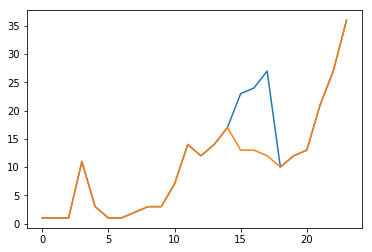

In [130]:
x = [i for i in range(0, 24)]
y2 = df_pm["2018/01/09"]


plt.plot(x, y1)
plt.plot(x, y2)

## 分析部分